In [1]:
from selenium import webdriver
import time
import random
from bs4 import BeautifulSoup
import re
from datetime import datetime
import json
import pandas as pd

In [2]:
fname = './data/검색결과_아리따움_3000_12131056.csv'
datas = pd.read_csv(fname)

## 검색결과 불러오기

In [3]:
print(len(datas))

2999


In [5]:
datas.head()

,﻿writer,article,likes,replys_count,replys,datetime,img,tags
0,totokodeog_motd,오늘의 립-#아리따움 #젤리바 #멜팅슈#토니모리 #립톤겟잇틴트 #레드핫#넘버7 #하...,4310,8,"(1, 'themonthapril', '@aoibhok'), (2, 'discoso...",2017-12-09 13:04,https://scontent-icn1-1.cdninstagram.com/t51.2...,"'#아리따움', '#젤리바', '#멜팅슈', '#토니모리', '#립톤겟잇틴트', '..."
1,aritaum_official,[로맨틱 홀리데이_LET IT SNOW]아직도 겨울네일 뭐할지 고민중이시라구요?-차...,537,1,'0',2017-12-13 01:34,https://scontent-icn1-1.cdninstagram.com/t51.2...,"'#크리스마스네일', '#연말네일', '#고요한밤', '#로맨틱홀리데이', '#셀프..."
2,fascinate_s,호잇 새로운 아이메이크업영상이!!원브랜드꿀조합 담아봤으니 불토! 불일!에 도전해봐요...,526402,55,"(1, 'youngju42835', '영상 올라오자마자 바로 봣습니당~'), (2,...",2017-12-01 10:40,https://scontent-icn1-1.cdninstagram.com/t51.2...,"'#뷰티유튜버', '#아리따움', '#색조합', '#아이메이크업', '#eyemak..."
3,hanyulofficial,"입술이 갈라지기 쉬운 겨울,#자연감성 으로 향기롭고 촉촉하게 케어하세요. #자연을닮...",370,2,"(1, 'ilovenail.wonju', '잘 보고 갑니다✌'), (2, 'stto...",2017-12-12 02:34,https://scontent-icn1-1.cdninstagram.com/t51.2...,"'#자연감성', '#자연을닮은립밤_', '#한율립밤', '#한율자연템', '#립밤'..."
4,betweendots,Do you wait for your Black Friday and pre-Blac...,202,11,"(1, 'properrosy', 'I still have like 4 to come...",2017-12-12 19:33,https://scontent-icn1-1.cdninstagram.com/t51.2...,"'#aritaum', '#kbeauty', '#abcommunity', '#rasi..."


In [6]:
datas['likes'].fillna(0)

0         4310
1          537
2       526402
3          370
4          202
5         1909
6          677
7          167
8          689
9           18
10           3
11          26
12          10
13          39
14          35
15          13
16         230
17          15
18          31
19          37
20          18
21           1
22          16
23          34
24          33
25           4
26          33
27          42
28          30
29          18
         ...  
2969        80
2970       179
2971        32
2972        59
2973       195
2974       147
2975        29
2976        42
2977        34
2978        11
2979        54
2980        29
2981        11
2982       303
2983       362
2984        49
2985       100
2986        38
2987        55
2988        38
2989       145
2990        11
2991        24
2992        11
2993        18
2994       130
2995        17
2996        13
2997         3
2998         6
Name: likes, dtype: int64

In [4]:
datas.dtypes

﻿writer         object
article         object
likes            int64
replys_count     int64
replys          object
datetime        object
img             object
tags            object
dtype: object

# 분석하기

### 시계열 분석하기

In [5]:
def insta_trends_analyser(datas):
    # datas: insta 크롤 결과 pandas 자료형 형태
    datas['day'] = [date[:10] for date in datas['datetime']]    # #월/일 값만 추가  2017-11-25형태
    
    trends = pd.DataFrame()
    trends['article'] = datas.groupby(datas['day'])['article'].count()  #  일자별 인스타 포스팅수
    trends['replies'] = datas.groupby(datas['day'])['replys_count'].sum() # 일자별 댓글 작성수
    trends['likes'] = datas.groupby(datas['day'])['likes'].sum()     # 일자별 좋아요 수
    trends['sum'] = trends.replies + trends.article + trends.likes
    
    return trends

In [6]:
insta_trends = insta_trends_analyser(datas)

In [10]:
insta_trends.head()

,article,replies,likes,sum
day,,,,
2017-11-10,12,28,471,511
2017-11-11,42,247,3456,3745
2017-11-12,53,385,6357,6795
2017-11-13,49,268,3092,3409
2017-11-14,45,291,4752,5088


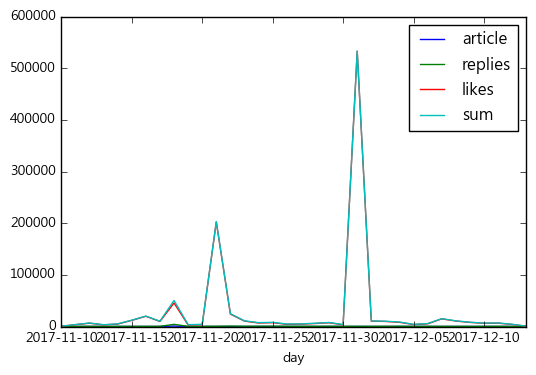

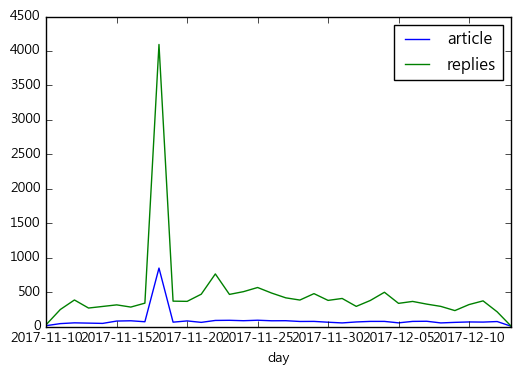

In [15]:
%matplotlib inline
# trends.plot(y = ['article','replys','sum'], ylim=(0,trends['sum'].max()))
insta_trends.plot(y = ['article','replies','likes','sum'])
insta_trends.plot(y = ['article','replies'])

### 태그 분석하기: 빈도수

In [7]:
# 태그 빈도수 계산하기

from collections import Counter

def tag_counter(tag_lists):
    # 인스타 태그 수집결과를 입력하면, 태그 빈도수 카운트가 높은 순으로 보여줌  
    # tag_lists = ["'#라인1태그1'",    "'라인2태그1', '라인2태그2', '라인2태그3'" ] 형식
    
    tag_counts = Counter()
    for tags in tag_lists:
        try: tag_counts.update(tags.replace("'",'').replace(' ','').strip().split(','),)
        except: continue
    tag_counts = tag_counts.most_common()  # 정열하기
    
    return tag_counts

In [8]:
# 상위 태그 그림그리기

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

def tag_counts_chart(tag_counts, n):
    # matplotlib 한글 사용하기
    font_location = 'c:/Windows/fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=font_location).get_name()
    rc('font',family=font_name)
    
    labels, values = [],[]
    for tags in reversed(tag_counts[:n]):   # 가로 그래프일 경우에는 reversed 로 순서 변경해준다
        label, value = tags
        labels.append(label)
        values.append(value)

    indexes = np.arange(len(labels))
    width = 1
    fig = plt.figure(figsize = (8,5))
    plt.barh(indexes, values, width)  # 수평 바 그래프
    plt.yticks(indexes + width * 0.5, labels, rotation='0')

    # 세로그래프일 경우
    # plt.bar(indexes, values, width)
    # plt.xticks(indexes + width * 0.5, labels, rotation='90') 
    plt.show()

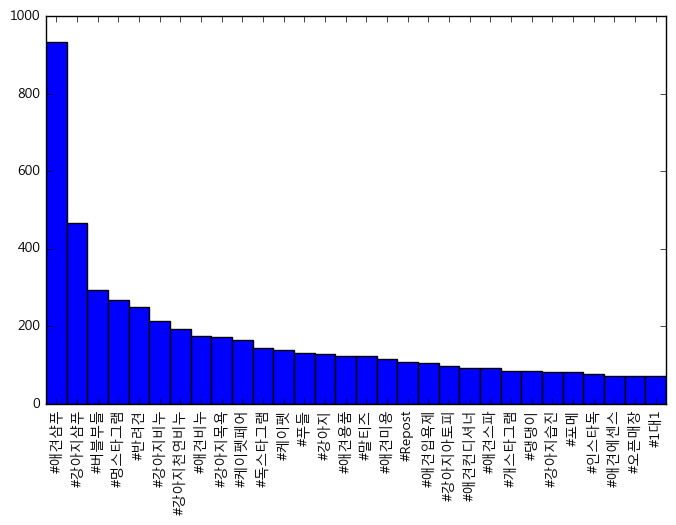

In [128]:
# 참고) 바차트 그리기
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# matplotlib 한글 사용하기
font_location = 'c:/Windows/fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font',family=font_name)

labels, values = [],[]

for tags in tag_counts[:30]:   # 가로 그래프일 경우에는 reversed 로 순서 변경해준다
    label, value = tags
    labels.append(label)
    values.append(value)

indexes = np.arange(len(labels))
width = 1
fig = plt.figure(figsize = (8,5))
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels, rotation='90')
plt.show()


### tag분석: 워드클라우드

In [9]:
# STOPWORD 제외
def tag_counts_sellector(tag_counts, STOP):
    # STOP 단어를 제외하여  리스트 형태로 출력함(카운터 --> 리스트 형태 변경됨)
    tag_counts_e = []
    for word, count in tag_counts:
        if word not in STOP:
            tag_counts_e.append((word,count))
    return tag_counts_e

In [17]:
# 워드클라우드 그리기

%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

def tag_wordcloud(tag_counts, word_num):
    tmp = dict(tag_counts[:word_num])
    wordcloud=WordCloud(font_path="c:/Windows/Fonts/malgun.ttf", relative_scaling=0.5, 
                        background_color="white", max_words=100).generate_from_frequencies(tmp)    #font_step=5
    plt.figure(figsize=(8,6))
    plt.imshow(wordcloud)
    plt.axis('off')

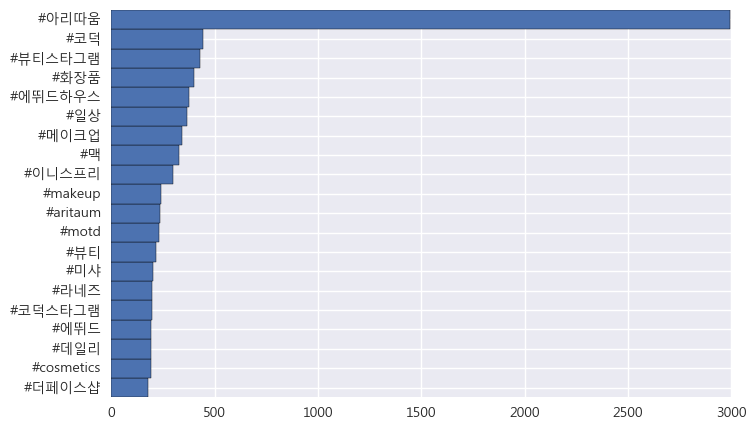

In [18]:
# 태그 빈도 분석1: 집계

tag_lists = datas['tags'].tolist() # 인스타 크롤링 결과 중 태그를 가져온다
tag_counts = tag_counter(tag_lists)  # 태그 카운트 집계한다
tag_counts_chart(tag_counts, 20)    # 시각화1) 상위 태그 그래프로 확인함


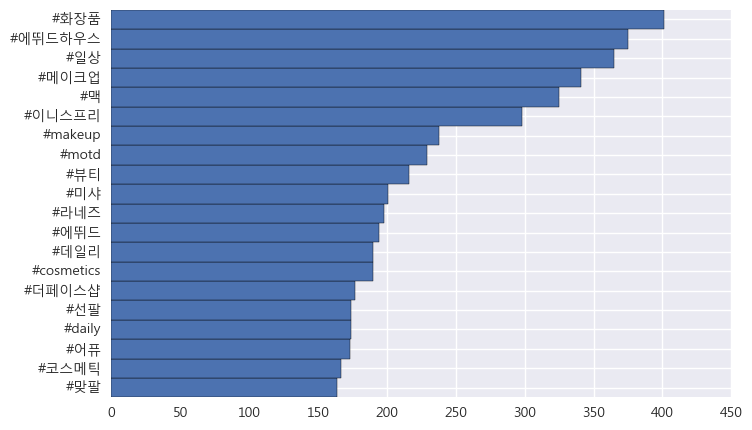

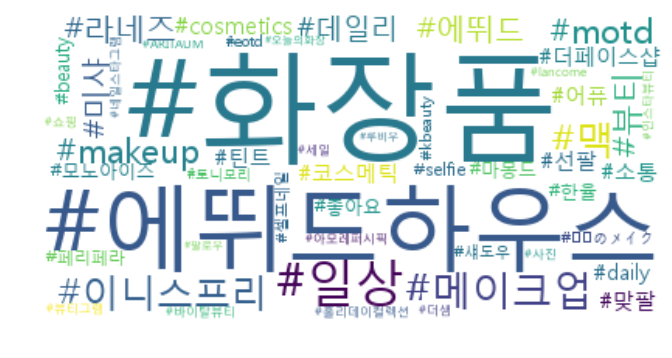

In [19]:
# 태그 빈도 분석2: 정리하기
STOP = ['#아리따움','#코덕','#뷰티스타그램','#aritaum','#코덕스타그램','#뷰스타그램']

tag_counts_selected = tag_counts_sellector(tag_counts, STOP)    # 불용어 데이터 확인한다
tag_counts_chart(tag_counts_selected, 20)    # 시각화1) 상위 태그 그래프로 확인함
tag_wordcloud(tag_counts_selected,50)        # 시각화2) 워드클라우드 그리기

## 2) SNA

In [20]:
# 단어 관계 행렬 쓰기 
from collections import Counter
from itertools import combinations


In [21]:
# 게시글별 태그리스트 정리한다

def tag_lists_selector(tag_lists, STOP):
    
    # 인스타 태그 검색결과 중 일부
    
    tag_lists_sel = []
    for tags in tag_lists:
        tag_sel = tags.replace("'",'').replace(' ','').split(',')
        tag_lists_sel.append(tag_sel)
    return tag_lists_sel
  

In [22]:
# 단어 관계 행렬 쓰기 
from collections import Counter
from itertools import combinations


def word_matrix(tag_lists, stop=None, must=None):
    # 매트릭스 만들기
    word_cooc_mat=Counter()
    for line in tag_lists:
        for word1, word2 in combinations(line,2):
            if stop!=None and (word1 in stop or word2 in stop): continue
            if must!=None and (word1 not in must and word2 not in must): continue
            if word1 == word2: continue  #동일한 단어간의 벡터는 계산하지 않음
            elif word_cooc_mat[(word2,word1)]>=1:word_cooc_mat[(word2,word1)]+=1
            else: word_cooc_mat[(word1,word2)]+=1    
    
    word_coocs = []
    for words, count in word_cooc_mat.items():
        word_coocs.append((words[0],words[1],count))
    
    sorted_word_coocs = sorted(word_coocs, key=lambda x: x[2], reverse=True)   # 정렬하기
    
    return sorted_word_coocs

In [27]:
#그래프 그리기
import networkx as nx
import matplotlib.pyplot as plt
import sys

def word_sna_graph(word_matrix, n, fname=None):
    G= nx.Graph()
    for word1, word2, count in word_matrix[:n]:    #상위 n개로만 그림 그리기
        G.add_edge(word1, word2, weight=count)
    
    T = nx.minimum_spanning_tree(G)
    nodes = nx.nodes(T)
    degrees = nx.degree(T)
    node_size = []

    for node in nodes:
        ns = degrees[node]*200
        node_size.append(ns)

    if sys.platform in ["win32", "win64"]: font_name = "malgun gothic"
    elif sys.platform == "darwin": fornt_name = "AppleGothic"
    plt.figure(figsize=(16,13))    
    nx.draw(T,
           pos=nx.fruchterman_reingold_layout(G, k=0.5),
           node_size=node_size,
           node_color="#FFE27F",
           font_family=font_name,
           label_pos=0, #0=head, 0.5=center, 1=tail
            with_labels=True,
            font_size=10 )
    if fname!=None: 
        plt.savefig(fname)
        print('{}에 저장하였습니다'.format(fname))
    plt.axis("off")

    plt.show()    

In [ ]:
#그래프 그리기
import networkx as nx
T = nx.Graph()
T.add_edge('#에뛰드하우스')
T.add_edge('#코덕')

[('#에뛰드하우스', '#맥', 381), ('#이니스프리', '#에뛰드하우스', 381), ('#이니스프리', '#맥', 340), ('#에뛰드하우스', '#메이크업', 195), ('#이니스프리', '#메이크업', 187), ('#메이크업', '#맥', 172), ('#맥', '#루비우', 169), ('#에뛰드하우스', '#루비우', 167), ('#이니스프리', '#노을지는하늘', 166), ('#노을지는하늘', '#맥', 166), ('#이니스프리', '#피오니가피어나', 166), ('#에뛰드하우스', '#피오니가피어나', 166), ('#피오니가피어나', '#맥', 166), ('#잭버건디', '#에뛰드하우스', 166), ('#노을지는하늘', '#에뛰드하우스', 166), ('#이니스프리', '#잭버건디', 166), ('#이니스프리', '#루비우', 166), ('#잭버건디', '#맥', 166), ('#makeup', '#메이크업', 149), ('#화장품', '#메이크업', 129)]


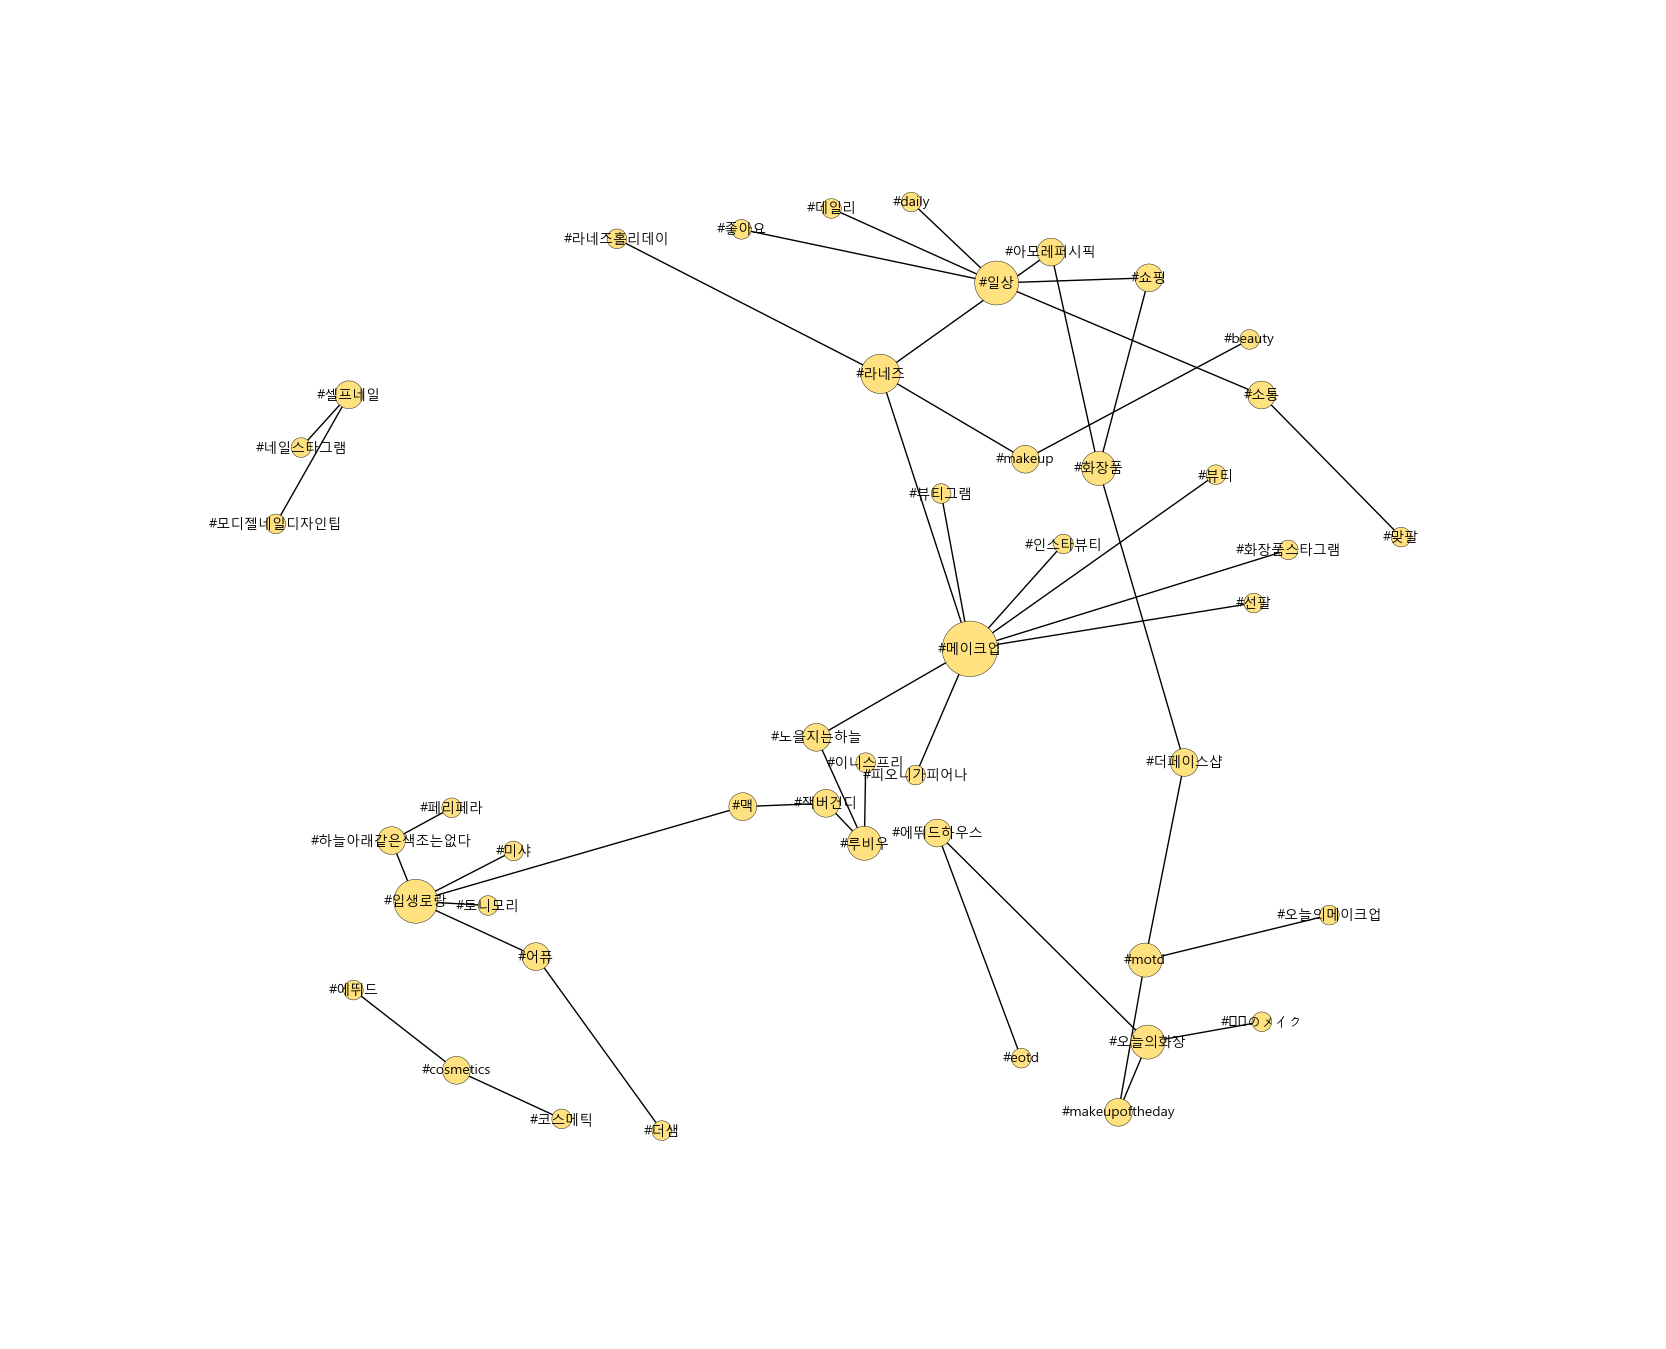

In [26]:
STOP = ['#아리따움','#코덕','#뷰티스타그램','#aritaum','#코덕스타그램','#뷰스타그램','#']
# must = ['#강아지습진', '#강아지샴푸','#강아지비누']
must = None

tag_lists = datas['tags'].dropna().tolist() # 인스타 크롤링 결과 중 태그를 가져온다
tag_lists_selected = tag_lists_selector(tag_lists,STOP)
word_cooc = word_matrix(tag_lists_selected, stop=STOP, must=must)
print(word_cooc[:20])

# fname = './data/아리따움v1_100'
# word_sna_graph(word_cooc,100,fname) #저장할경우

word_sna_graph(word_cooc,100)


In [40]:
# 특정단어 트랜드 분석

In [44]:
check = ['#입생로랑' in str(tags) for tags in datas.tags]
datas[check]

,﻿writer,article,likes,replys_count,replys,datetime,img,tags,day
65,vnletter,#할리스#고구마라떼🍠#먹스타그램🍴#아리따움#프레시파워에센스마스크#쉐어버터#오늘의파우...,9,2,"(1, 'jjuninajjang', '잘봤어요~ 자주 소통나누고 지내요~✨💫'), ...",2017-12-12 02:48,https://scontent-icn1-1.cdninstagram.com/t51.2...,"'#할리스', '#고구마라떼🍠', '#먹스타그램🍴', '#아리따움', '#프레시파워...",2017-12-12
277,si_0326,카페☕️..#추운 #겨울 #따뜻한 #카페 #에서 #수다떨기 #아리따움 #섀도우팔레트...,25,1,"(1, '_m___j1022', '꿀잼~~~~~또갈ㄹ래')",2017-12-08 14:06,https://scontent-icn1-1.cdninstagram.com/t51.2...,"'#추운', '#겨울', '#따뜻한', '#카페', '#에서', '#수다떨기', '...",2017-12-08
388,twinkle.clara,#화장품아무도 #안물안궁 이지만...ㅋㅋ 제가 쓰는 메이크업 제품 몇개 소개 합니당...,37,8,"(1, 'so_jeong.120', 'ㅋㅋㅋ 좋은정보 감사여언니 저두클리오킬블랙쓰는...",2017-12-07 02:53,https://scontent-icn1-1.cdninstagram.com/t51.2...,"'#화장품아무도', '#안물안궁', '#마스카라', '#랑콤버츄어스', '#블러셔'...",2017-12-07
390,yndm222,한때 지니고 다녔던아가들 😘단종되어 없는 템들도 !?#여자라면누구나#화장품#립스틱#...,15,4,"(1, 'ziggycroz', 'Very cool!'), (2, 'yndm222',...",2017-12-07 01:29,https://scontent-icn1-1.cdninstagram.com/t51.2...,"'#여자라면누구나', '#화장품', '#립스틱', '#립글로즈', '#아리따움', ...",2017-12-07
508,ansser24_,🌺주왕주왕 립메이크업🌺립메이크업이라고 할것도 없는 그저 틴트 발색... 예전에 #아...,8,1,'0',2017-12-05 06:20,https://scontent-icn1-1.cdninstagram.com/t51.2...,"'#아리따움', '#할인', '#행사', '#아리따움', '#컬러라이브틴트', '#...",2017-12-05
509,seonbinii,꺄 너무추어-#광주 #흔녀 #selfie #selca #daily #일상 #시험기간...,94,6,"(1, 'ro_sha___', '빛나는 나를 더 빛나게 할 예쁘고 저렴한 악세서리 ...",2017-12-05 05:16,https://scontent-icn1-1.cdninstagram.com/t51.2...,"'#광주', '#흔녀', '#selfie', '#selca', '#daily', '...",2017-12-05
651,dd_ccong,¥20171203.'ㅡ'TWO호우의일상#독서⠀⠀⠀⠀⠀⠀⠀누군가의 말 한마디가 소년에...,264,1,"(1, 'beauty_theqoo', ""뷰티더쿠들 보시오! '뷰티더쿠'에서 뷰티 정...",2017-12-03 06:38,https://scontent-icn1-1.cdninstagram.com/t51.2...,"'#독서⠀⠀⠀⠀⠀⠀⠀누군가의', '#인천', '#알라딘', '#중고서점', '#책'...",2017-12-03
659,iwantthatredvelvet,김태랑이 내 앞머리 깜찍이라고 했어 ㅇㅅㅇ #motd #urbandecay #mid...,115,1,"(1, 'k.taerang', '김태랑입니다. 깜찍이스타일 찾아쥴래다가 인생 밑바닥...",2017-12-03 05:10,https://scontent-icn1-1.cdninstagram.com/t51.2...,"'#motd', '#urbandecay', '#midnightcowbow', '#y...",2017-12-03
660,iwantthatredvelvet,김태랑이 내 앞머리 깜찍이라고 했어 ㅇㅅㅇ #motd #urbandecay #mid...,115,1,"(1, 'k.taerang', '김태랑입니다. 깜찍이스타일 찾아쥴래다가 인생 밑바닥...",2017-12-03 05:10,https://scontent-icn1-1.cdninstagram.com/t51.2...,"'#motd', '#urbandecay', '#midnightcowbow', '#y...",2017-12-03
977,im_jinvely,어떤 메이크업이든 전부 소화가능하신 뚜렷한 이목구비를 가지신 고객님❤️이목구비에서 ...,51,6,"(1, '_95_1214', '완벽한 메이크업이에요 너무 고마워요옹😖👍🏻'), (2...",2017-11-28 07:24,https://scontent-icn1-1.cdninstagram.com/t51.2...,"'#입생로랑', '#올아워파운데이션', '#아리따움', '#리얼앰플브라이트너', '...",2017-11-28


In [45]:
def insta_trends_word(datas, word):
    datas['day'] = [date[:10] for date in datas['datetime']]    # #월/일 값만 추가  2017-11-25형태
    check = [word in str(tags) for tags in datas.tags]

    trends = pd.DataFrame()
    trends['article'] = datas[check].groupby(datas['day'])['article'].count()  #  일자별 인스타 포스팅수
    trends['replies'] = datas[check].groupby(datas['day'])['replys_count'].sum() # 일자별 댓글 작성수
    trends['likes'] = datas[check].groupby(datas['day'])['likes'].sum()     # 일자별 좋아요 수
    trends['sum'] = trends.replies + trends.article + trends.likes
    
    return trends

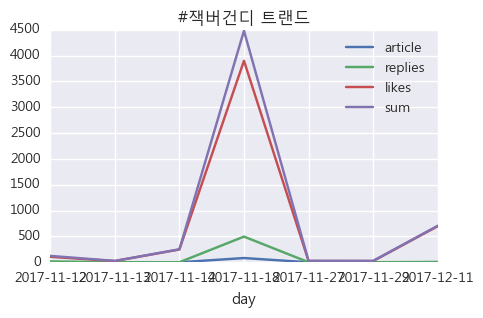

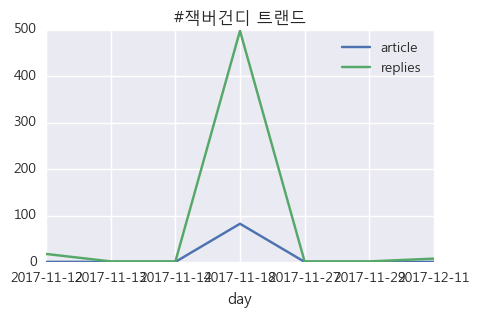

In [51]:
WORD = '#잭버건디'
word_trends = insta_trends_word(datas, WORD)
word_trends.plot(y = ['article','replies','likes','sum'], title = '{} 트랜드'.format(WORD), figsize=(5,3))
word_trends.plot(y = ['article','replies'], title = '{} 트랜드'.format(WORD),figsize=(5,3))